# Iterative Method for Barycenter Computation
**GPU-only implementation.**

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
from torch import nn
from torch.nn import functional as F

from scipy.stats import ortho_group
from scipy.linalg import sqrtm

from src.icnn import DenseICNN_U
from src.plotters import plot_training_phase
from src.tools import ewma, score_gen, freeze, unfreeze
from src.fid_score import calculate_frechet_distance
from src import distributions
from src import bar_benchmark
import itertools

import gc
from sklearn.decomposition import PCA

from copy import deepcopy

%load_ext autoreload
%autoreload 2

## Config

In [2]:
DIM = 2
assert DIM > 1

GPU_DEVICE = 0
BATCH_SIZE = 1024

LAMBDA = 10
G_LR = 1e-4
D_LR = 1e-3
MAX_ITER = 10001

D_ITERS = 50
T_ITERS = 10
G_ITERS = 50

PLOT_FREQ = 499
SCORE_FREQ = 499

# Parameters for input distributions
NUM = 3
ALPHAS = np.array([1. / NUM for _ in range(NUM)])

CASE = {
    'type' : 'EigWarp', 
    'sampler' : 'Rectangles', #'Gaussians', #'SwissRoll',# , #
    'params' : {'num' : NUM, 'alphas' : ALPHAS, 'min_eig' : .5, 'max_eig' : 2}
}


OUTPUT_SEED = 0xBADBEEF

In [3]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.is_available())


1
True


In [4]:

assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

np.random.seed(OUTPUT_SEED)
torch.manual_seed(OUTPUT_SEED)

## Initializing distributions

In [5]:
if CASE['type'] == 'EigWarp':
    if CASE['sampler'] == 'Gaussians':
        sampler = distributions.StandardNormalSampler(dim=DIM)
    elif CASE['sampler'] == 'SwissRoll':
        assert DIM == 2
        sampler = distributions.SwissRollSampler()
    elif CASE['sampler'] == 'Rectangles':
        sampler = distributions.CubeUniformSampler(dim=DIM, normalized=True, centered=True)
    
    benchmark = bar_benchmark.EigenWarpBenchmark(sampler, **CASE['params'])

## Discriminators Setup

In [6]:
D = nn.Sequential(
    nn.Linear(DIM, max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), 1)
).cuda()

T = nn.Sequential(
    nn.Linear(DIM, max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), DIM)
).cuda()

In [7]:
Ds = nn.ModuleList([deepcopy(D) for _ in range(benchmark.num)]).cuda()
Ts = nn.ModuleList([deepcopy(T) for _ in range(benchmark.num)]).cuda()

Ds_inv = nn.ModuleList([deepcopy(D) for _ in range(benchmark.num)]).cuda()
Ts_inv = nn.ModuleList([deepcopy(T) for _ in range(benchmark.num)]).cuda()

## Generator Setup

In [8]:
# For now DIM_Z = DIM_X
Z_sampler = distributions.StandardNormalSampler(dim=DIM)

In [9]:
G = nn.Sequential(
    nn.Linear(DIM, max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Dropout(0.005),
    nn.Linear(max(100, 2*DIM), max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Dropout(0.005),
    nn.Linear(max(100, 2*DIM), max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), DIM)
).cuda()

In [10]:
G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-8)
loss = np.inf

G.train(True)

for iteration in tqdm_notebook(range(10000)):
    Z = Z_sampler.sample(BATCH_SIZE).detach() * 3
    loss = F.mse_loss(Z, G(Z))
    loss.backward()
    G_opt.step(); G_opt.zero_grad()
    if loss.item() < 1e-2:
        break

print(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)


## PCA

In [11]:
pca = PCA(n_components=2)

class Identity:
    pass

if benchmark.bar_sampler is not None:
    pca.fit(benchmark.bar_sampler.sample(100000).cpu().detach().numpy())
elif benchmark.gauss_bar_sampler is not None:
    pca.fit(benchmark.gauss_bar_sampler.sample(100000).cpu().detach().numpy())
else:
    pca = Identity()
    pca.transform = lambda x: x
    
# No PCA for dim=2
if DIM == 2:
    pca = Identity()
    pca.transform = lambda x: x

## Main training

In [12]:
G_opt = torch.optim.Adam(G.parameters(), lr=G_LR, weight_decay=1e-10)
Ts_opt, Ds_opt = [], []
Ts_inv_opt, Ds_inv_opt = [], []
for k in range(benchmark.num):
    Ts_opt.append(torch.optim.Adam(Ts[k].parameters(), lr=D_LR, weight_decay=1e-10))
    Ds_opt.append(torch.optim.Adam(Ds[k].parameters(), lr=D_LR, weight_decay=1e-10))
    Ts_inv_opt.append(torch.optim.Adam(Ts_inv[k].parameters(), lr=D_LR, weight_decay=1e-10))
    Ds_inv_opt.append(torch.optim.Adam(Ds_inv[k].parameters(), lr=D_LR, weight_decay=1e-10))

In [13]:
G_loss_history = []

G_UVP_history = []

if hasattr(benchmark, 'gauss_bar_cost'):
    print('Gaussian Barycenter Cost:', benchmark.gauss_bar_cost)

Gaussian Barycenter Cost: 0.964035669962565


In [14]:
it = 0
last_plot_it = -1
last_score_it = -1

Iteration 5950
G-UVP: 0.10160883231719461%


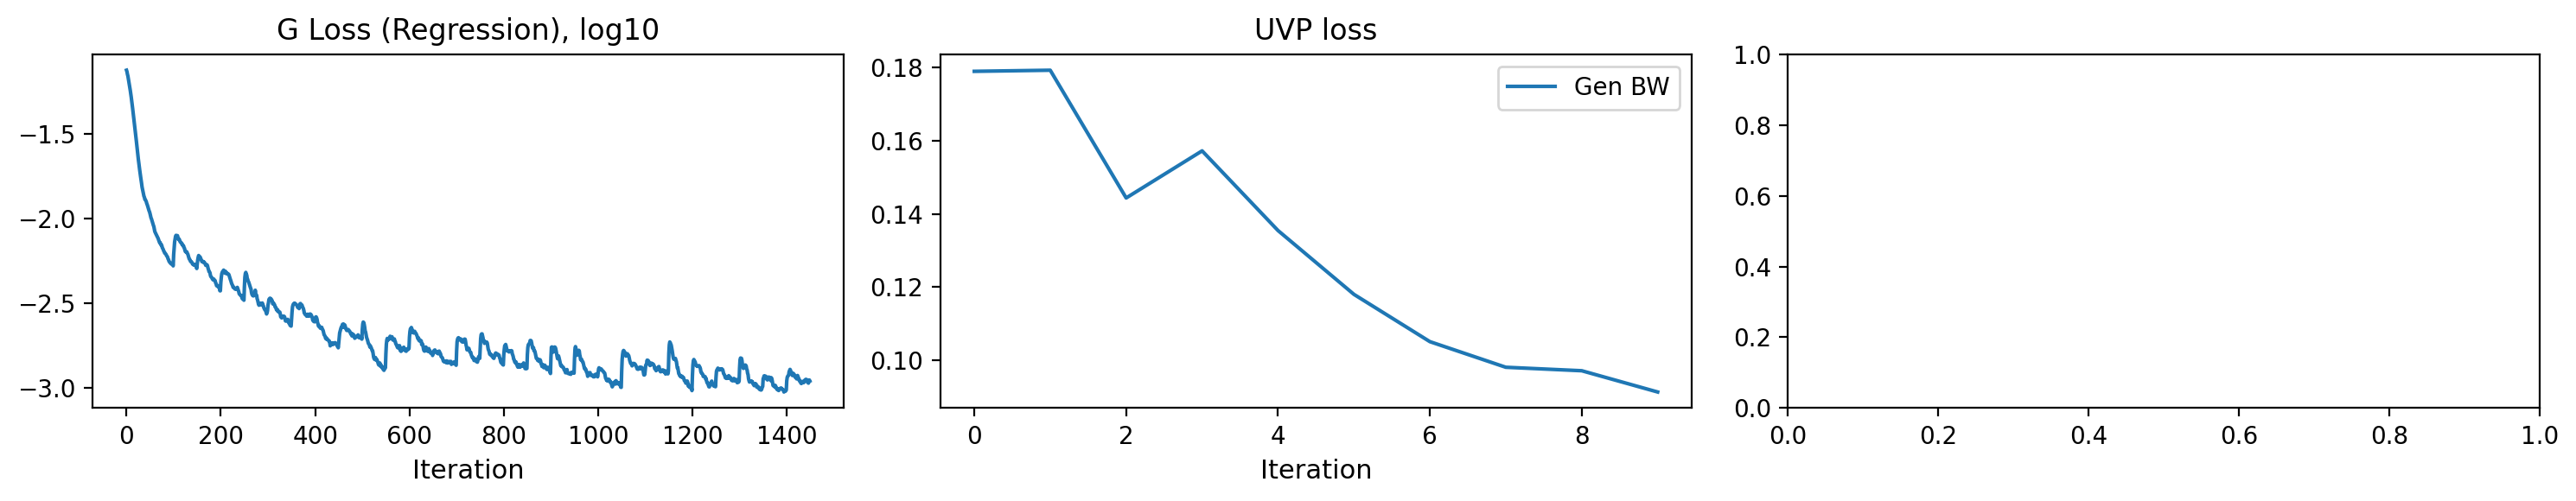

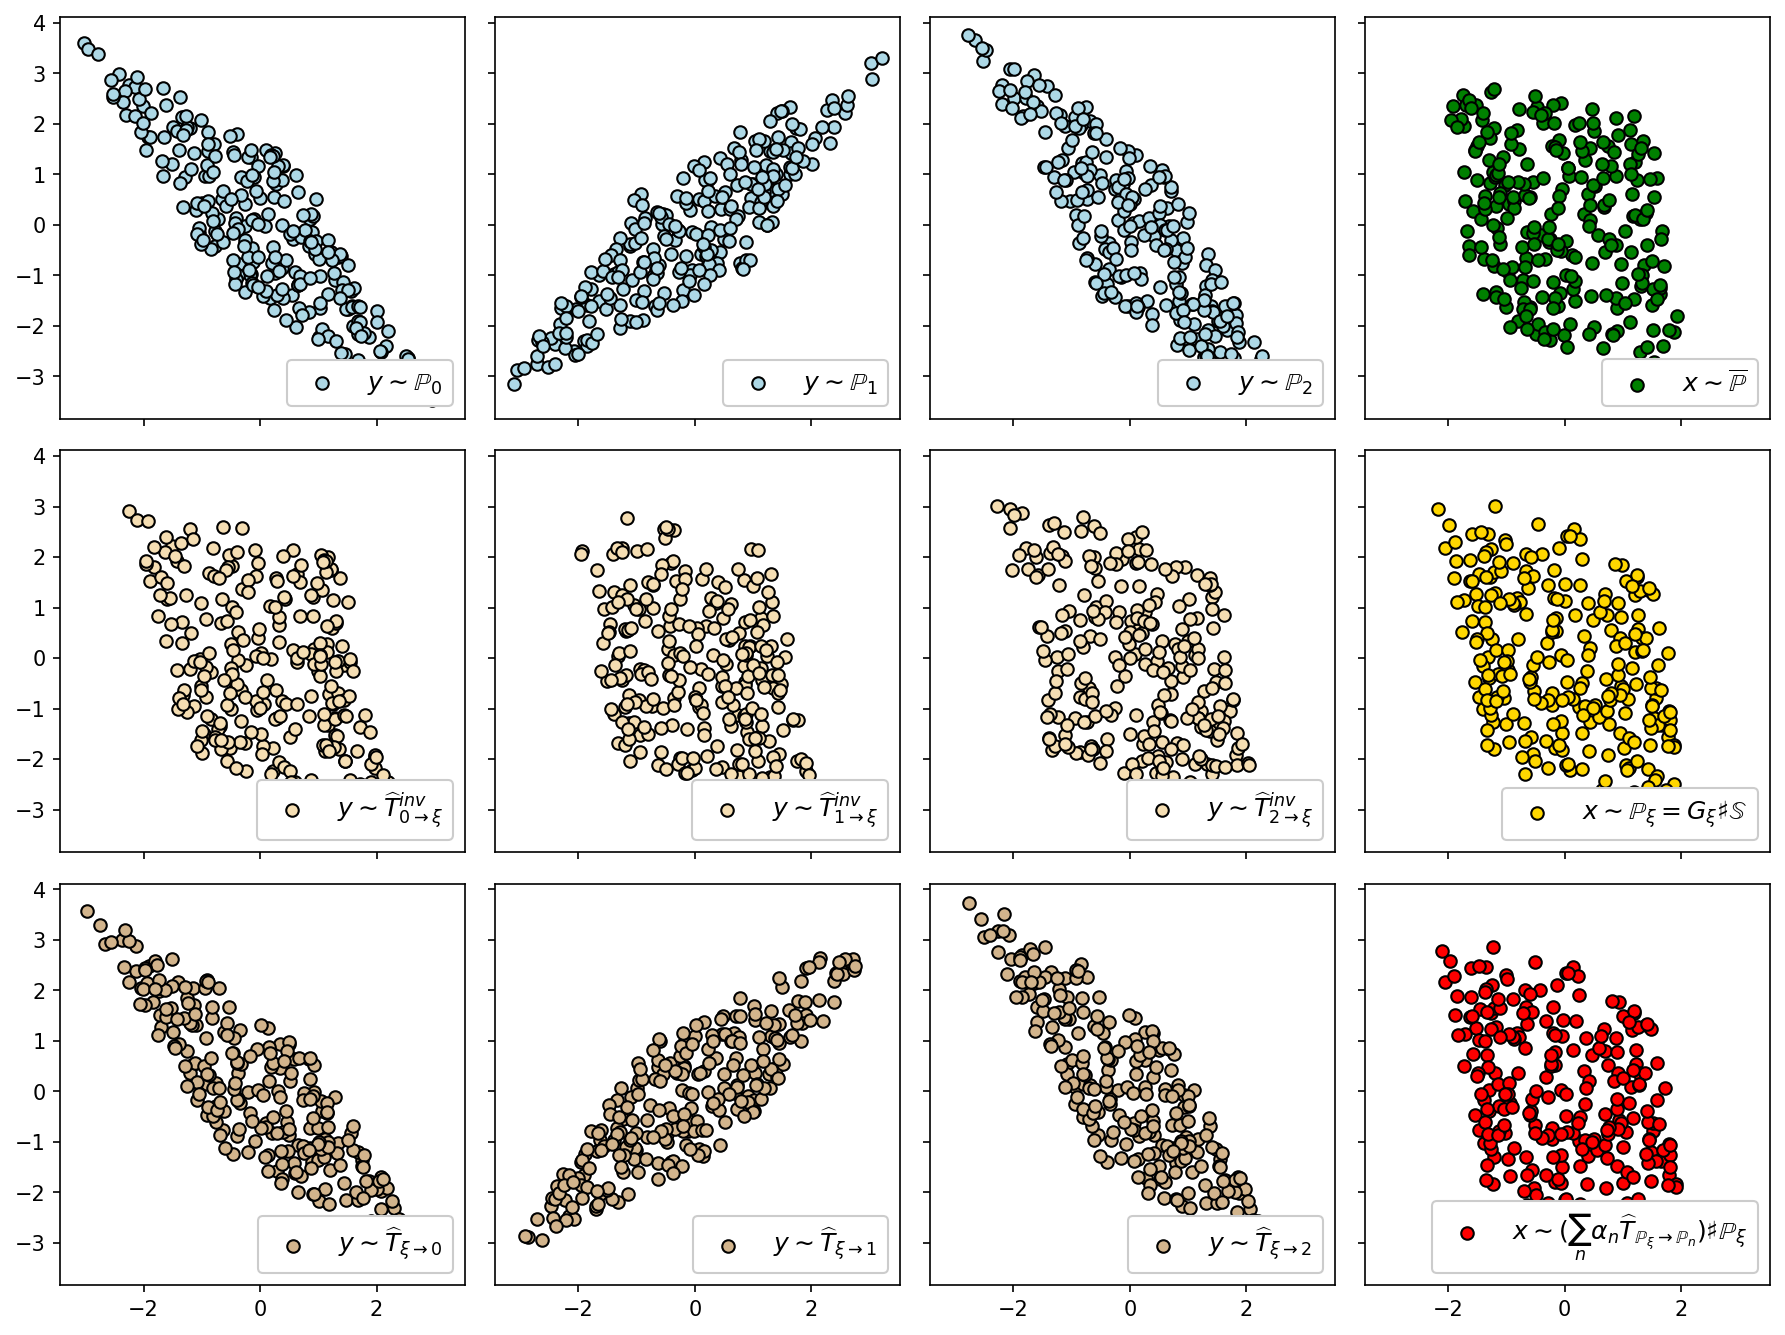

 42%|████▏     | 21/50 [00:16<00:22,  1.30it/s]


KeyboardInterrupt: 

In [15]:
while it < MAX_ITER:
    freeze(G)
    for k in range(benchmark.num):
        # D and T optimization cycle
        for d_iter in tqdm(range(D_ITERS)):
            it += 1

            # T optimization
            unfreeze(Ts[k]); freeze(Ds[k])
            for t_iter in range(T_ITERS): 
                with torch.no_grad():
                    X = G(Z_sampler.sample(BATCH_SIZE))
                Ts_opt[k].zero_grad()
                T_X = Ts[k](X)
                T_loss = F.mse_loss(X, T_X).mean() - Ds[k](T_X).mean()
                T_loss.backward(); Ts_opt[k].step()
            del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

            # D optimization
            with torch.no_grad():
                X = G(Z_sampler.sample(BATCH_SIZE))
            Y = benchmark.samplers[k].sample(BATCH_SIZE)
            
            unfreeze(Ds[k]); freeze(Ts[k])
            T_X = Ts[k](X).detach()
            Ds_opt[k].zero_grad()
            D_loss = Ds[k](T_X).mean() - Ds[k](Y).mean()
            D_loss.backward(); Ds_opt[k].step();
            del D_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
            
            # T inv optimization
            unfreeze(Ts_inv[k]); freeze(Ds_inv[k])
            for t_iter in range(T_ITERS): 
                Y = benchmark.samplers[k].sample(BATCH_SIZE)
                Ts_inv_opt[k].zero_grad()
                T_inv_Y = Ts_inv[k](Y)
                T_inv_loss = F.mse_loss(Y, T_inv_Y).mean() - Ds_inv[k](T_inv_Y).mean()
                T_inv_loss.backward(); Ts_inv_opt[k].step()
            del T_inv_loss, T_inv_Y, Y; gc.collect(); torch.cuda.empty_cache()

            # D inv optimization
            Y = benchmark.samplers[k].sample(BATCH_SIZE)
            with torch.no_grad():
                X = G(Z_sampler.sample(BATCH_SIZE))
            
            unfreeze(Ds_inv[k]); freeze(Ts_inv[k])
            T_inv_Y = Ts_inv[k](Y).detach()
            Ds_inv_opt[k].zero_grad()
            D_inv_loss = Ds_inv[k](T_inv_Y).mean() - Ds_inv[k](X).mean()
            D_inv_loss.backward(); Ds_inv_opt[k].step();
            del D_inv_loss, Y, X, T_inv_Y; gc.collect(); torch.cuda.empty_cache()
    
    # Scoring
    if it - last_score_it >= SCORE_FREQ:
        last_score_it = it
        if benchmark.gauss_bar_sampler is not None:
            G_UVP = score_gen(benchmark, G, Z_sampler, score_size=100000)
            G_UVP_history.append(G_UVP)
    
    # Plotting
    if it - last_plot_it >= PLOT_FREQ:
        clear_output(wait=True)
        print('Iteration', it)
        last_plot_it = it        
        
        # Plotting Metrics
        fig, axes = plt.subplots(1, 3, figsize=(15, 3), dpi=200)
        
        axes[0].set_title('G Loss (Regression), log10', fontsize=12)
        axes[0].set_xlabel('Iteration', fontsize=11)
        axes[0].plot(np.log10(ewma(G_loss_history, span=10)))
        
        axes[1].set_title('UVP loss', fontsize=12)
        axes[1].set_xlabel('Iteration', fontsize=11)
        axes[1].plot(ewma(G_UVP_history, span=20), label='Gen BW')
        axes[1].legend()
        
        print('G-UVP: {}%'.format(np.mean(G_UVP_history[-10:])))
        
        fig.tight_layout(); plt.show(); plt.close(fig)
        
        # Plotting scatter plots
        fig, ax = plot_training_phase(benchmark, pca, Ts, Ts_inv, G, Z_sampler)
        fig.tight_layout();
        plt.show(); plt.close(fig)
        
    # G optimization
    if G_ITERS > 0:
        for k in range(benchmark.num):
            freeze(Ts[k])
        G_old = deepcopy(G); freeze(G_old)
        unfreeze(G)
        for g_iter in range(G_ITERS):
            it += 1
            Z = Z_sampler.sample(BATCH_SIZE)
            with torch.no_grad():
                G_old_Z = G_old(Z)
                T_G_old_Z = torch.zeros_like(G_old(Z))
            G_old_Z.requires_grad_(True)
            for k in range(benchmark.num):
                T_G_old_Z += ALPHAS[k] * Ts[k](G_old_Z)

            G_opt.zero_grad()
            G_loss = .5 * F.mse_loss(G(Z), T_G_old_Z)
            G_loss.backward(); G_opt.step() 

            G_loss_history.append(G_loss.item())

        del G_old, G_loss, T_G_old_Z, Z
        gc.collect(); torch.cuda.empty_cache()